# COVID Forecasting

Notebook adapted from Patrick Sánchez's [kernel](https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions/notebook) as part of [COVID19 Global Forecasting](https://www.kaggle.com/c/covid19-global-forecasting-week-1).

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from scipy import integrate, optimize

from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder

import glob

In [2]:
# Path to input csvs
DATA_DIR = "csse_covid_19_daily_reports/"

# Dates to model
MIN_DATE = '2020-03-01'
MAX_DATE = '2020-04-03'

# Individual countries to model
MODEL_COUNTRIES = ["Italy", "Spain", "Germany"]

In [3]:
def build_aggregate_df():

    agg_df = None

    for fn in glob.glob(DATA_DIR + "*.csv"):
        df = pd.read_csv(fn)
        df["Date"] = fn.split("/")[-1].split(".csv")[0]
        df.rename(columns={
            "Country/Region": "Country_Region", 
            "Province/State": "Province_State",
            "Deaths": "Fatalities",
            "Confirmed": "ConfirmedCases"
        }, inplace=True)
        if agg_df is None:
            agg_df = df
        else:
            agg_df = agg_df.append(df, ignore_index=True)

    # Type Conversions
    agg_df["Date"] = pd.to_datetime(agg_df["Date"])
    agg_df.sort_values("Date", inplace=True)
    
    # Handle nulls
    agg_df["Province_State"].fillna("Other", inplace=True)
    
    # Column Selection
    cols = ["Date", "Province_State", "Country_Region", "Fatalities", "ConfirmedCases"]
    
    # Aggregate at date, country, state grain
    agg_df = agg_df[cols].groupby(by=["Date", "Province_State", "Country_Region"]).sum()
    agg_df = agg_df.reset_index()
    agg_df = agg_df[cols]
    

    print("Num Rows:", agg_df.shape[0])
    print("Total Dates:", agg_df["Date"].unique().shape[0])
    print("Min Date:", agg_df["Date"].min())
    print("Max Date:", agg_df["Date"].max())
    
    return agg_df

train = build_aggregate_df()

train.head()

Num Rows: 11614
Total Dates: 73
Min Date: 2020-01-22 00:00:00
Max Date: 2020-04-03 00:00:00


,Date,Province_State,Country_Region,Fatalities,ConfirmedCases
0,2020-01-22,Anhui,Mainland China,0.0,1.0
1,2020-01-22,Beijing,Mainland China,0.0,14.0
2,2020-01-22,Chongqing,Mainland China,0.0,6.0
3,2020-01-22,Fujian,Mainland China,0.0,1.0
4,2020-01-22,Gansu,Mainland China,0.0,0.0


## Add Derived Features

In [4]:
all_data = train.copy()
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = LabelEncoder()
all_data['DayNum'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

### Demographic Data

In [5]:
# Load countries data file
world_population = pd.read_csv("population_by_country_2020.csv")

# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

# Now join the dataset to our previous DataFrame and clean missings (not match in left join)- label encode cities
all_data = all_data.merge(world_population, left_on='Country_Region', right_on='Country (or dependency)', how='left')
all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)

### Feature Encoding

In [6]:
# Label encode countries and provinces. Save dictionary for exploration purposes
all_data.drop('Country (or dependency)', inplace=True, axis=1)
all_data['Country_Region'] = le.fit_transform(all_data['Country_Region'].astype(str))
number_c = all_data['Country_Region']
countries = le.inverse_transform(all_data['Country_Region'])
country_dict = dict(zip(countries, number_c)) 
all_data['Province_State'] = le.fit_transform(all_data['Province_State'].astype(str))
number_p = all_data['Province_State']
province = le.inverse_transform(all_data['Province_State'])
province_dict = dict(zip(province, number_p)) 

print("Encoded dataset")

all_data.head()

Encoded dataset


,Date,Province_State,Country_Region,Fatalities,ConfirmedCases,DayNum,Day,Month,Year,Population (2020),Density,Land Area,Med Age,Urban Pop
0,2020-01-22,8,129,0.0,1.0,0,22,1,2020,0.0,0.0,0.0,0.0,0.0
1,2020-01-22,15,129,0.0,14.0,0,22,1,2020,0.0,0.0,0.0,0.0,0.0
2,2020-01-22,37,129,0.0,6.0,0,22,1,2020,0.0,0.0,0.0,0.0,0.0
3,2020-01-22,76,129,0.0,1.0,0,22,1,2020,0.0,0.0,0.0,0.0,0.0
4,2020-01-22,78,129,0.0,0.0,0,22,1,2020,0.0,0.0,0.0,0.0,0.0


## Linear Regression By Country

In [7]:
# Filter selected features
data = all_data.copy()

features = [
    'DayNum',
    'Country_Region', 
    'Province_State', 
    'ConfirmedCases',
    'Fatalities',
]

data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log1p(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)


def split_data(data, shift):
    """Split data into train and test sets"""
    
    # Test set
    x_test = data.drop(['ConfirmedCases', 'Fatalities'], axis=1)
    
    # Train on only date through shift
    data = data[data.DayNum<data.DayNum.min()+shift]
    
    # Train set
    x_train = data.drop(['ConfirmedCases', 'Fatalities'], axis=1)
    y_train_1 = data['ConfirmedCases']
    y_train_2 = data['Fatalities']
    
    return x_train, y_train_1, y_train_2, x_test


def lin_reg(X_train, Y_train, X_test, degree=1):
    """Linear regression model"""
    # Build model with polynomial features
    regr = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred

In [8]:
def plot_linreg_basic_country(data, country_name, day_start, shift, degree=1):
    
    dates_list = pd.date_range(MIN_DATE, MAX_DATE).strftime('%Y-%m-%d').tolist()
    
    data_country = data[data['Country_Region']==country_dict[country_name]]
    data_country = data_country.loc[data_country['DayNum']>=day_start]
    X_train, Y_train_1, Y_train_2, X_test = split_data(data_country, shift)
    model, pred = lin_reg(X_train, Y_train_1, X_test, degree=degree)

    # Create a df with both real cases and predictions
    X_train_check = X_train.copy()
    X_train_check['Target'] = Y_train_1

    predicted_data = X_test.copy()
    predicted_data['Target'] = pred

    # Select predictions
    predicted_data = predicted_data.loc[(predicted_data['DayNum'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle((f"Confirmed Cases Log-Linear Regression for {country_name}, {degree} Degrees"))

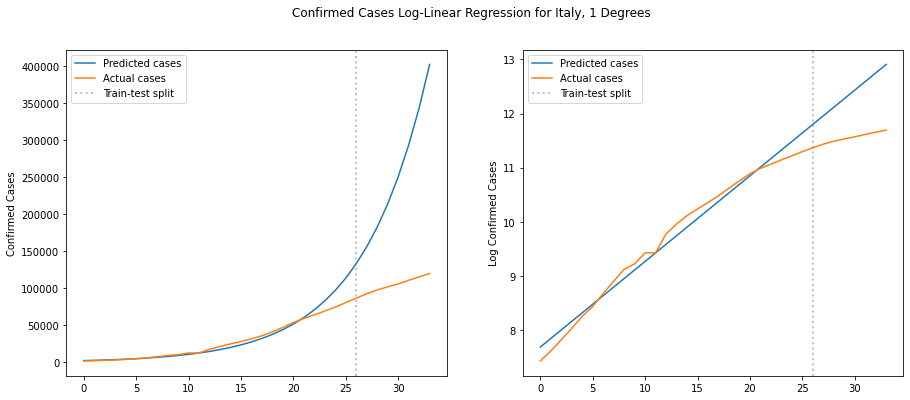

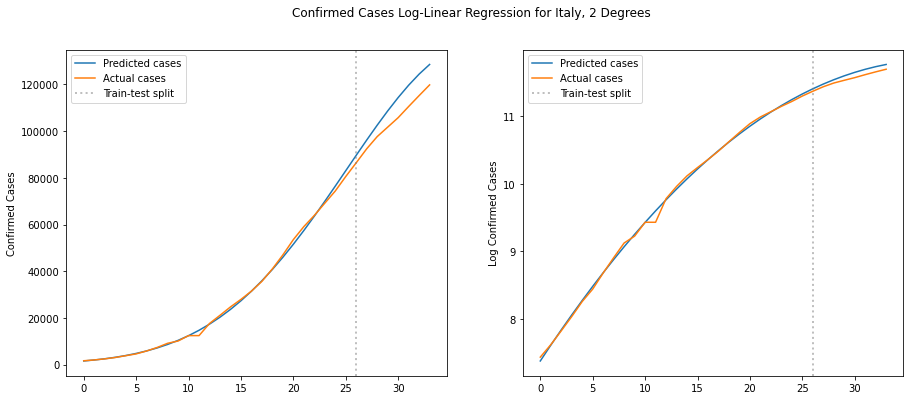

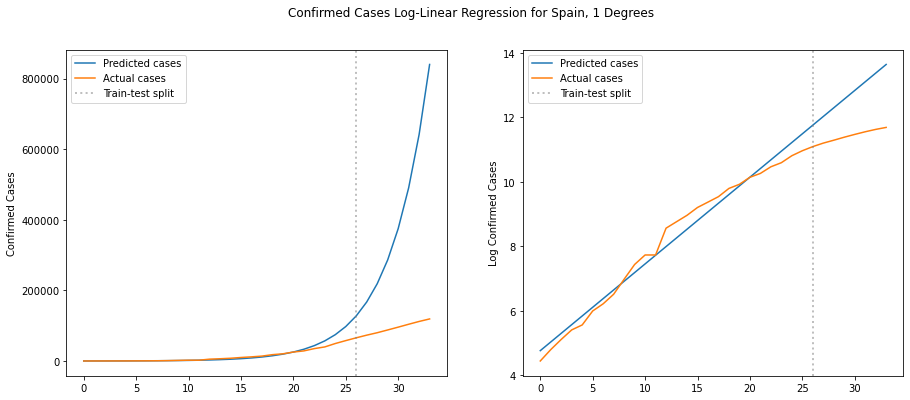

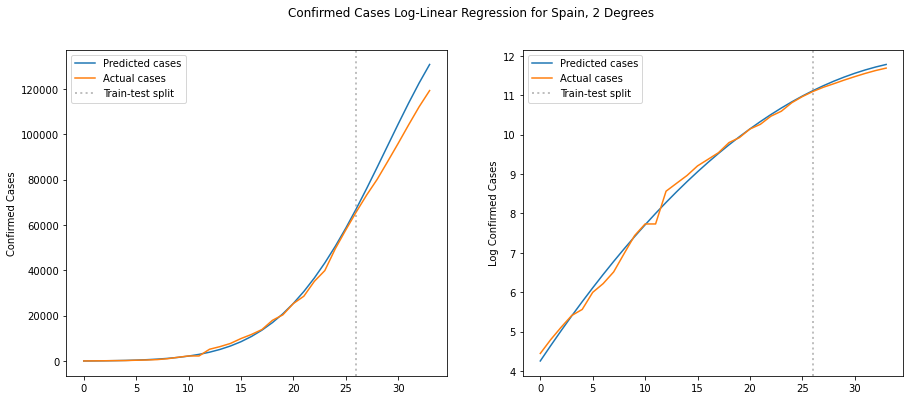

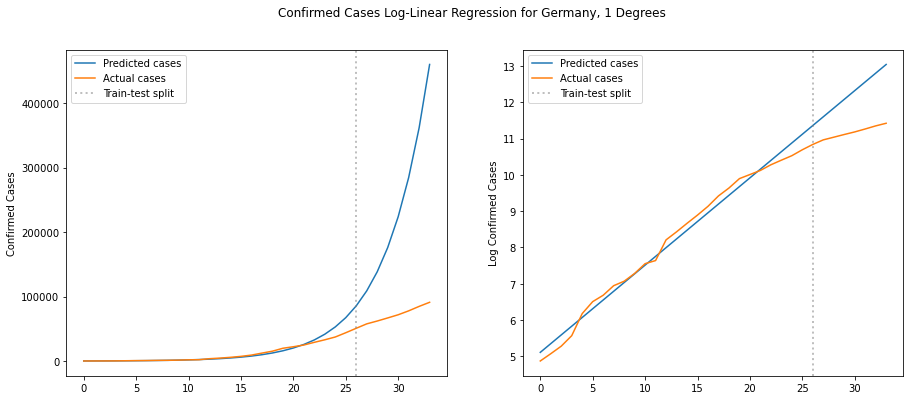

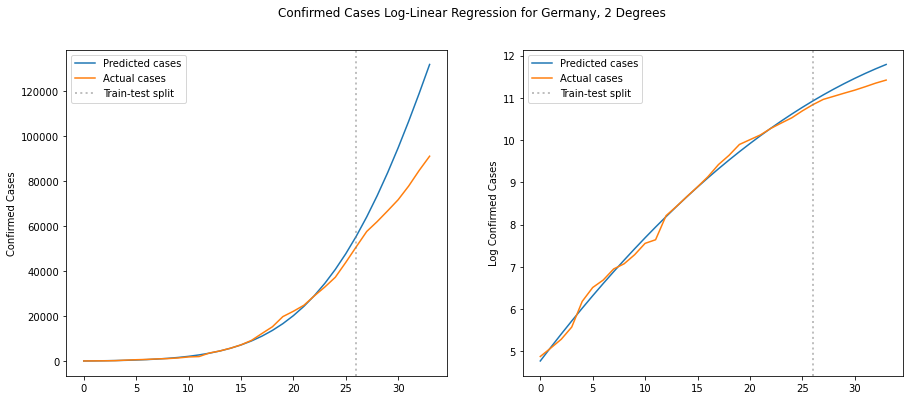

In [9]:
degrees_to_plot = [1, 2]

for country_name in MODEL_COUNTRIES:
    for degree in degrees_to_plot:
        plot_linreg_basic_country(data, country_name, 39, 26, degree=degree)

## SIR Model By Country

In [10]:
def fa(N, a, b, beta):
    """Susceptible equation"""
    fa = -beta*a*b
    return fa


def fb(N, a, b, beta, gamma):
    """Infected equation"""
    fb = beta*a*b - gamma*b
    return fb


def fc(N, b, gamma):
    """Recovered/deceased equation"""
    fc = gamma*b
    return fc


def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    """
    Runge-Kutta method of 4rth order for 3 dimensions 
    (susceptible a, infected b and recovered r)
    """
    
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    
    return a, b, c

In [11]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

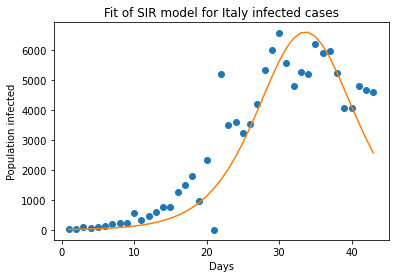

Optimal parameters: beta = 15.296513418513658  and gamma =  15.071443723505832


In [12]:
population = float(60480000)
country_df = pd.DataFrame()
country_df['ConfirmedCases'] = train.loc[train['Country_Region']=='Italy'].ConfirmedCases.diff().fillna(0)

# Limit plot to more recent data
country_df = country_df[21:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = country_df.ConfirmedCases
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Italy infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [13]:
# Todo: for data with provinces, aggregate first